# Define MHWs using Hobday definition

In [1]:
import xarray as xr
import pandas as pd
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy import stats
from scipy.stats import linregress
from xrft import detrend
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
import matplotlib.dates as mdates
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram
import geopandas as gpd
import regionmask
import gsw

In [2]:
gpath = '/work5/stb/MHW-gfdl/Collab-LG_SS/cmems_mod_glo_phy_my_0.083deg_P1M-m_so-thetao_98.00W-80.00W_17.00N-31.00N_0.49-5727.92m_1993-01-01-2025-08-01.nc'
#esm4_path = '/work5/stb/ESM4/historical_1850-2014/ts/ocean_monthly_z.*.*.nc'
oisst_path = '/work5/stb/MHW-gfdl/Collab-LG_SS/OISST_gom_1981-2025_daily_sst.nc'
era_path = '/work/Shanice.Bailey/MHW-gfdl/compare_avgs_trends/ERA5/ds_era5.nc'

cora = xr.open_dataset('/work5/stb/MHW-gfdl/cora.nc', chunks={})
glorys_ds = xr.open_dataset(gpath, chunks={})
#ds_z = xr.open_mfdataset(esm4_path, chunks={}, decode_timedelta=True)
oisst_ds = xr.open_dataset(oisst_path)#, chunks={})
era = xr.open_dataset(era_path, chunks={})

|  | OISST | CORA | GLORYS | ERA5 | SPEAR |
| :----------: | :----------: | :----------: | :----------: | :----------: | :----------: |
| Temperature | SST | 3D | 3D | SST |
| Sampling<br>frequency | Daily | Monthly | Monthly | Daily |   |
| Lat/Lon<br>resolution | 0.25˚ x 0.25˚ | 0.1˚ x 0.5˚ | 1/12˚ x 1/12˚ | 0.25˚ x 0.25˚ |   |
|Time period | 1981-09 : 2025-09 | 1980-01 : 2024-06 | 1993-01 : 2025-08 | 1983-01 : 2021-06 |   |

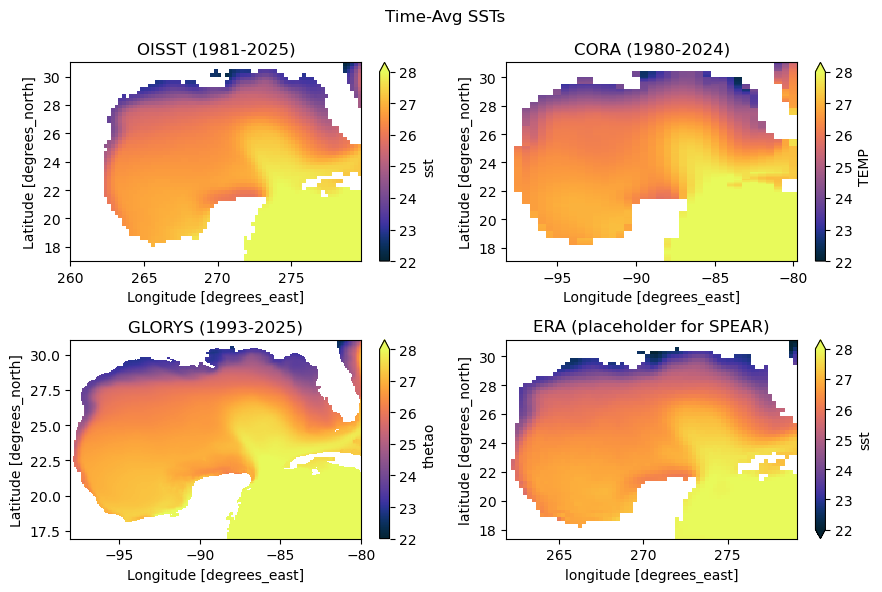

In [4]:
fig, ax = plt.subplots(2,2, figsize=(9,6))
oisst.mean('time').plot(ax=ax[0,0], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
ax[0,0].set_title('OISST (1981-2025)')
cora.TEMP.isel(depth=0).mean('time').plot(ax=ax[0,1], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
ax[0,1].set_title('CORA (1980-2024)')
glorys_ds.thetao.isel(depth=0).mean('time').plot(ax=ax[1,0], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
ax[1,0].set_title('GLORYS (1993-2025)')
era.sst.mean('time').plot(ax=ax[1,1], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
ax[1,1].set_title('ERA (placeholder for SPEAR)')
plt.suptitle('Time-Avg SSTs')
plt.tight_layout();

## Detrend

In [3]:
def linear_trend_line(da, da_name, coord_name=None):
    
    d = {}
    d[f'{da_name}_trend_lr'] = linregress(np.arange(0, da.time.size), da.mean([da.dims[1], da.dims[2]]))
    d[f'{da_name}_trend_line_lr'] = (d[f'{da_name}_trend_lr'][0]*np.arange(0,da.time.size) 
                                     + d[f'{da_name}_trend_lr'][1])
    return d

In [4]:
def yrly_linear_trend(da):
    d = da.groupby('time.year').mean('time').polyfit('year', deg=1, skipna=True, cov=True)

    return d

In [5]:
#start w OISST to establish workflow
oisst = oisst_ds.sst.sel(lon=slice(None, 279.625))

In [6]:
linear_trend_line(oisst, oisst.name)

{'sst_trend_lr': LinregressResult(slope=np.float64(6.911383219221099e-05), intercept=np.float64(25.931747054173012), rvalue=np.float64(0.13600566236439082), pvalue=np.float64(2.473545896848942e-67), stderr=np.float64(3.967840722402651e-06), intercept_stderr=np.float64(0.03688299864184062)),
 'sst_trend_line_lr': array([25.93174705, 25.93181617, 25.93188528, ..., 27.04434152,
        27.04441064, 27.04447975])}

In [7]:
#Fits a polynomial to the data along the time dim
p = oisst.polyfit(dim='time', deg=1) #('degree', 'lat', 'lon'){:16101, :56, :79}

#Solves for each element/term in the polynomial (essentially solves for x). Is that right?
fit = xr.polyval(oisst.time, p.polyfit_coefficients) #('time', 'lat','lon'){:16101, :56, :79}

#detrended da along time dim
detrended_intime = oisst - fit 

In [8]:
detrended_intime

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 570MB
array([[[       nan,        nan,        nan, ..., 0.56249045,
         0.61682021, 0.62065052],
        [       nan,        nan,        nan, ..., 0.73312377,
         0.75378651, 0.81314929],
        [       nan,        nan,        nan, ..., 0.8020876 ,
         0.85973364, 0.94598217],
        ...,
        [       nan,        nan,        nan, ..., 3.10062762,
         2.83790433, 2.88615597],
        [       nan,        nan,        nan, ..., 3.42294399,
         3.08692153, 2.91810974],
        [       nan,        nan,        nan, ..., 3.68840716,
         3.25868274, 2.97429929]],

       [[       nan,        nan,        nan, ..., 0.65242615,
         0.73675493, 0.86058641],
        [       nan,        nan,        nan, ..., 0.89305961,
         0.92372294, 0.98308597],
        [       nan,        nan,        nan, ..., 1.13202354,
         1.12967046, 1.13591725],
...
        [       nan,        nan,        nan, ..., 4.42173669,
         3.7155432 , 2.98889981],
        [       nan,        nan,        nan, ..., 4.68609461,
         3.9964043 , 3.25226161],
        [       nan,        nan,        nan, ..., 5.08845704,
         4.47995499, 3.77025527]],

       [[       nan,        nan,        nan, ..., 1.80490595,
         1.76289759, 1.67217779],
        [       nan,        nan,        nan, ..., 1.85251356,
         1.74903826, 1.60249053],
        [       nan,        nan,        nan, ..., 1.93180052,
         1.76505115, 1.56281654],
        ...,
        [       nan,        nan,        nan, ..., 4.40175307,
         3.78552349, 3.118842  ],
        [       nan,        nan,        nan, ..., 4.68612028,
         4.15639914, 3.512218  ],
        [       nan,        nan,        nan, ..., 5.07849843,
         4.62997146, 4.01023181]]])
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon      (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat      (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88

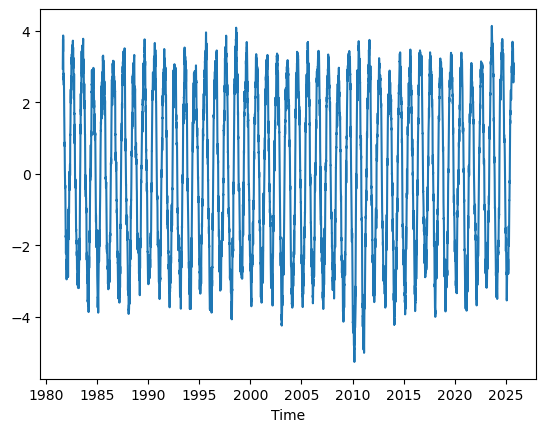

In [9]:
detrended_intime.mean(['lat','lon']).plot()

In [10]:
anom = oisst.groupby('time.day') - oisst.groupby('time.day').mean('time') 

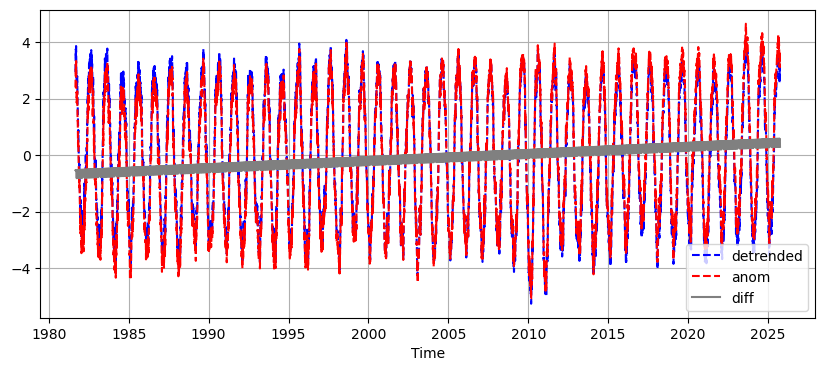

In [12]:
detrended_intime.mean(['lat','lon']).plot(label='detrended', color='b', linestyle='dashed', figsize=(10,4))
anom.mean(['lat','lon']).plot(label='anom', linestyle='dashed', color='r')
(anom.drop_vars('day') - detrended_intime).mean(['lat','lon']).plot(label='diff', color='grey')
plt.legend()
plt.grid()

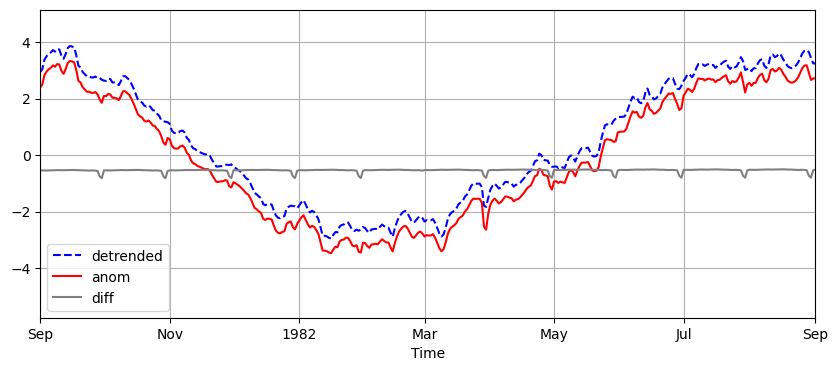

In [15]:
detrended_intime.mean(['lat','lon']).plot(label='detrended', color='b', linestyle='dashed', figsize=(10,4))
anom.mean(['lat','lon']).plot(label='anom', color='r')
(anom.drop_vars('day') - detrended_intime).mean(['lat','lon']).plot(label='diff', color='grey')
plt.legend()
plt.grid()
plt.xlim(detrended_intime.time[0], detrended_intime.time[365]);

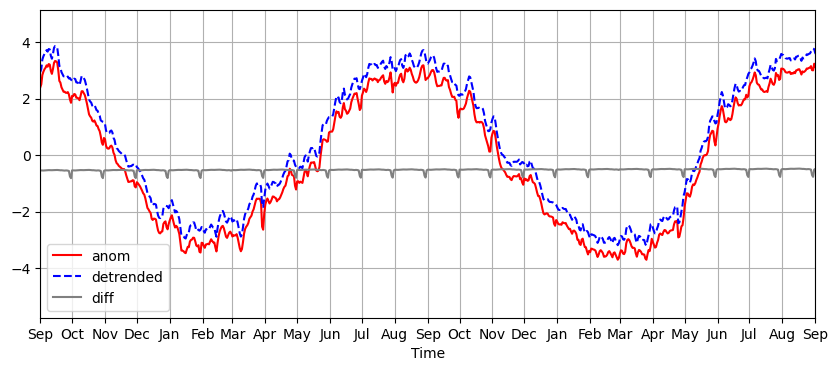

In [18]:
diff = (anom.drop_vars('day') - detrended_intime)
fig, ax = plt.subplots(figsize=(10, 4))
anom.mean(['lat','lon']).plot(label='anom', color='r', ax=ax)
detrended_intime.mean(['lat','lon']).plot(label='detrended', linestyle='dashed', color='b', ax=ax)
diff.mean(['lat','lon']).plot(label='diff', color='grey', ax=ax)
ax.set_xlim(detrended_intime.time[0], detrended_intime.time[365*2])
ax.legend()
ax.grid()
# Set the major locator to show ticks at the beginning of each month
ax.xaxis.set_major_locator(mdates.MonthLocator())
# Set the major formatter to display the month abbreviation
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"));

> What is captured in the difference between `anom` and `detrended` sst? Detrended takes out a linear warming signal from sst and `anom` represents the deviated SSTs from the average of SST over the whole time period, and includes the linear and nonlinear warming signal. So `no linear warming` minus `linear warming + nonlinear warming` equals ....? Difference captures non-linear variability or periodic deviations.

> Divets at the end of every month. Why does Every March not have a divet? Is anom and detrended array offset by a day?

## Break up data by seasons

In [55]:
def seasons(da):
    DJF = da.where(da.time.dt.month.isin([12, 1, 2]))
    MAM = da.where(da.time.dt.month.isin([3, 4, 5]))
    JJA = da.where(da.time.dt.month.isin([6, 7, 8]))
    SON = da.where(da.time.dt.month.isin([9, 10, 11]))
    seasons_ds = xr.merge([DJF.rename('winter'), MAM.rename('spring'), 
                           JJA.rename('summer'), SON.rename('autmun')])
    return seasons_ds

In [56]:
seasons(oisst)

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 16101, lon: 79, lat: 56)
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon      (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat      (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
Data variables:
    winter   (time, lat, lon) float32 285MB nan nan nan nan ... nan nan nan nan
    spring   (time, lat, lon) float32 285MB nan nan nan nan ... nan nan nan nan
    summer   (time, lat, lon) float32 285MB nan nan nan nan ... nan nan nan nan
    autmun   (time, lat, lon) float32 285MB nan nan nan ... 27.57 27.96 28.48
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.82]

In [57]:
clim = oisst_ds.sst.sel(lon=slice(None, 279.625)).groupby('time.dayofyear').mean('time')

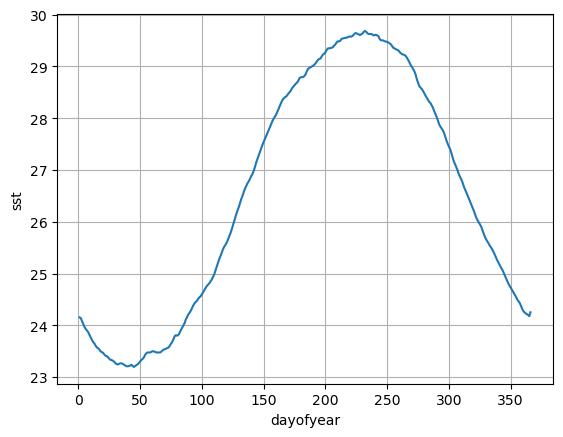

In [58]:
clim.mean(['lat','lon']).plot()
plt.grid()

## 90$^{th}$ Percentile, Duration count

In [61]:
#DETRENDED BLOCK
#Group by day of the year and then calculate the 90th percentile for each day
da_d = detrended_intime.groupby('time.dayofyear')
baseline_p90_d = da_d.quantile(0.9, dim='time') #('dayofyear', 'lat', 'lon'){:366, :56, :79}
#reindex and repeat the baseline_p90 array to match the full dataset's dayofyear
current_p90_threshold_d = baseline_p90_d.sel(dayofyear=oisst_ds.time.dt.dayofyear)#('time', 'lat', 'lon'){:16101, :56, :79}
#Identify temp/days where current temperature exceeds the 90th percentile baseline
exceedance_days_d = detrended_intime.where(detrended_intime > current_p90_threshold_d)
#Make boolean mask of days that exceed 90th percentile
exceedance_mask_bool_d = (detrended_intime > current_p90_threshold_d)
#Make boolean mask to int to count days for 5-day threshold
exceedance_int_d = exceedance_mask_bool_d.astype(int)
#Identify the events that are >=5 days
consecutive_exceedances_5D_d = exceedance_int_d.rolling(time=5, center=False).sum()
exceedance_periods_5D_d = consecutive_exceedances_5D_d >= 5
#Identify gaps of >=3 days (i.e., at least 3 consecutive False)
gap = (~exceedance_periods_5D_d).rolling(time=3).sum() >= 3
#A new event starts the *day after* a qualifying gap ends. Convert to int for cumulative sum
gap_shifted = gap.shift(time=1, fill_value=False).astype(int) #0==False, 1==True
#Cumulative sum assigns event IDs
event_id_cumsum = gap_shifted.cumsum()
# Mask out non-exceedance days
event_id = event_id_cumsum.where(exceedance_periods_5D_d, 0)

# Count the number of days exceeding the 90th percentile in a specific year:
target_year_exceedances_d = exceedance_days_d.sel(time='2015').count()
print('Number of days exceeding the 90th percentile in \033[1m 2015 \033[0m:' + 
f'\033[1m{target_year_exceedances_d.item():,}\033[0m')

target_year_exceedances_d = exceedance_days_d.sel(time='2020').count()
print('Number of days exceeding the 90th percentile in \033[1m 2020: \033[0m' + 
f'\033[1m{target_year_exceedances_d.item():,}\033[0m')

Number of days exceeding the 90th percentile in  2015 :143,504
Number of days exceeding the 90th percentile in  2020: 139,549


In [ ]:
import xarray as xr

def label_exceedance_events(exceedance_bool, min_event_length=5, min_gap=3):
    """
    Label SST exceedance events based on:
      - exceedance_bool: boolean array of daily exceedances (True = above 90th percentile)
      - min_event_length: number of consecutive days required to count as an event (default 5)
      - min_gap: number of consecutive non-exceedance days that separates events (default 3)
      
    Returns:
      DataArray of event IDs (0 = not part of any event)
    """

    # Step 1: rolling window to find 5-day exceedance periods
    consecutive = exceedance_bool.rolling(time=min_event_length, center=False).sum()
    event_days = consecutive >= min_event_length

    # Step 2: find gaps of ≥ min_gap that break events
    gap = (~event_days).rolling(time=min_gap).sum() >= min_gap

    # Step 3: shift by 1 day so the next exceedance gets a new event ID
    gap_shifted = gap.shift(time=1, fill_value=False).astype(int)

    # Step 4: cumulative sum assigns unique event labels
    event_id = gap_shifted.cumsum()

    # Step 5: mask out days that are not event days
    event_id = event_id.where(event_days, 0)

    return event_id


In [ ]:
# Boolean exceedance
exceed_bool = exceedance_int_d.astype(bool)

# Label event days
event_id = label_exceedance_events(
    exceed_bool,
    min_event_length=5,
    min_gap=3
)

# Build summary table
event_summary = summarize_events(
    event_id,
    sst=sst,
    sst_anom=sst_anom
)

event_summary


In [22]:
#Absolute Temp block
#Group by day of the year and then calculate the 90th percentile
da = oisst_ds.sst.sel(lon=slice(None, 279.625)).groupby('time.dayofyear')
baseline_p90 = da.quantile(0.9, dim='time')

#reindex the baseline_p90 to match the full dataset's dayofyear
current_p90_threshold = baseline_p90.sel(dayofyear=oisst_ds.time.dt.dayofyear)

#Identify days where current temperature exceeds the 90th percentile baseline
exceedance_days = oisst_ds.sst.where(oisst_ds.sst > current_p90_threshold)
#Make boolean mask of days that exceed 90th percentile
exceedance_mask_bool = (oisst_ds.sst > current_p90_threshold)
#Make boolean mask int to count days for 5-day threshold
exceedance_int = exceedance_mask_bool.astype(int)
#Identify the events that are >=5 days
consecutive_exceedances_5D = exceedance_int.rolling(time=5, center=False).sum()
exceedance_periods_5D = consecutive_exceedances_5D >= 5
consecutive_exceedances_30D = exceedance_int.rolling(time=30, center=False).sum()
exceedance_periods_30D = consecutive_exceedances_30D >= 30

# Count the number of days exceeding the 90th percentile in a specific year:
target_year_exceedances = exceedance_days.sel(time='2015').count()
print('Number of days exceeding the 90th percentile in \033[1m 2015 \033[0m:' + 
f'\033[1m{target_year_exceedances.item():,}\033[0m')

target_year_exceedances = exceedance_days.sel(time='2020').count()
print('Number of days exceeding the 90th percentile in \033[1m 2020: \033[0m' + 
f'\033[1m{target_year_exceedances.item():,}\033[0m')

Number of days exceeding the 90th percentile in  2015 :218,905
Number of days exceeding the 90th percentile in  2020: 299,701


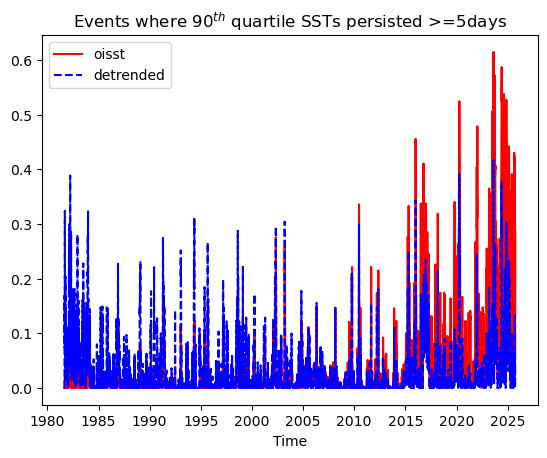

In [23]:
exceedance_periods_5D.mean(['lat', 'lon']).plot(label='oisst', color='r')
exceedance_periods_5D_d.mean(['lat', 'lon']).plot(label='detrended', color='b', linestyle='dashed')
plt.legend()
plt.title('Events where 90$^{th}$ quartile SSTs persisted >=5days');

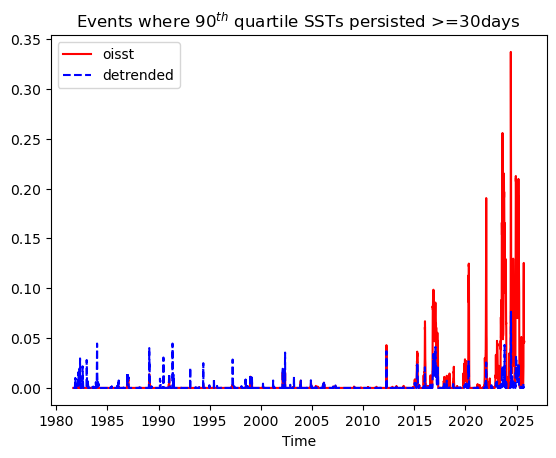

In [24]:
exceedance_periods_30D.mean(['lat', 'lon']).plot(label='oisst', color='r')
exceedance_periods_30D_d.mean(['lat', 'lon']).plot(label='detrended', color='b', linestyle='dashed')
plt.legend()
plt.title('Events where 90$^{th}$ quartile SSTs persisted >=30days');

In [25]:
#Sum up all the days that exceed 90th/5-day threshold in each year
yrs_list = np.unique(exceedance_days.time.dt.year)
exceedance_days_by_yr = []
for year in yrs_list:
    exceedance_days_by_yr.append(exceedance_days.sel(time=f'{year}').count())

In [26]:
exceedance_days.sel(time='2012').count()

<xarray.DataArray 'sst' ()> Size: 8B
array(100532)
Coordinates:
    quantile  float64 8B 0.9

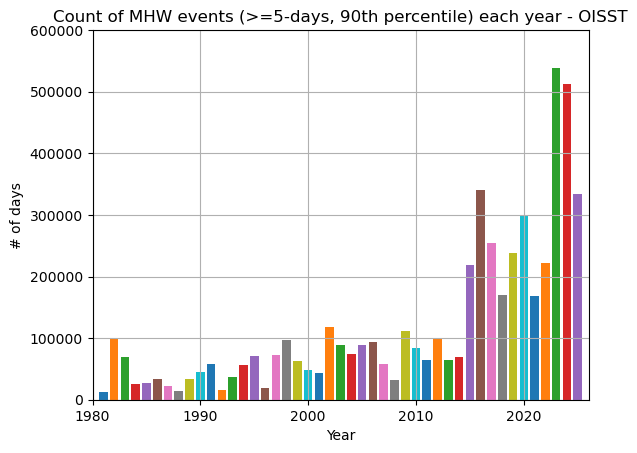

In [27]:
for (year, exc_days) in zip(yrs_list, exceedance_days_by_yr):
    plt.bar(year, exc_days)
plt.ylabel('# of days')
plt.xlabel('Year')
plt.ylim(0, 600000)
plt.xlim(1980, 2026)
plt.title('Count of MHW events (>=5-days, 90th percentile) each year - OISST')
plt.grid();

In [66]:
#Sum up all the days that exceed 90th/5-day threshold in each year
yrs_list = np.unique(event_id.time.dt.year)
exceedance_events_by_yr = []
for year in yrs_list:
    exceedance_events_by_yr.append(event_id.sel(time=f'{year}').count())

In [80]:
format(event_id.sel(time='2015').count(), ",") 

'1,614,760'

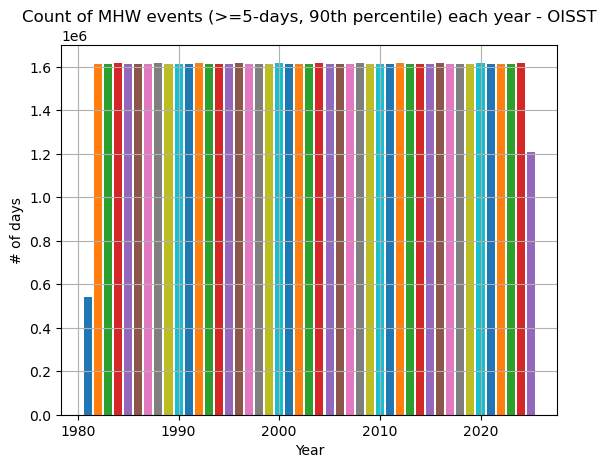

In [82]:
for (year, exc_events) in zip(yrs_list, exceedance_events_by_yr):
    plt.bar(year, exc_events)
plt.ylabel('# of days')
plt.xlabel('Year')
#plt.ylim(0, 600000)
#plt.xlim(1980, 2026)
plt.title('Count of MHW events (>=5-days, 90th percentile) each year - OISST')
plt.grid();

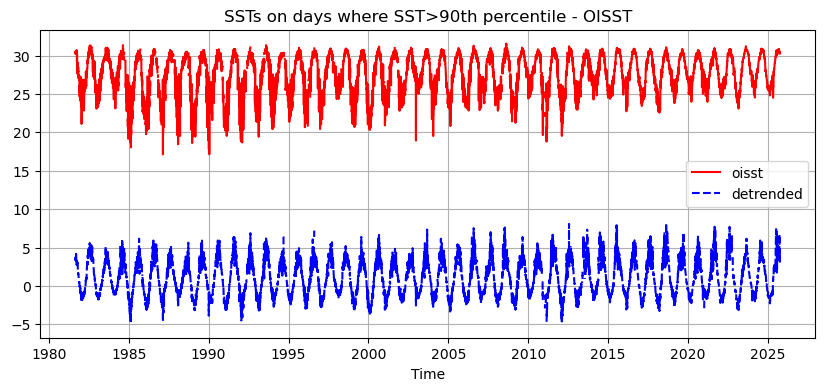

In [30]:
exceedance_days.mean(['lat', 'lon']).plot(label='oisst', color='r', figsize=(10,4))
exceedance_days_d.mean(['lat', 'lon']).plot(label='detrended', color='b', linestyle='dashed')
plt.grid()
#plt.ylim(17,32)
plt.title('SSTs on days where SST>90th percentile - OISST')
plt.legend(loc='best');